# Imports

In [4]:
import sys
sys.path.insert(0, "../")

import numpy as np
import pandas as pd
from ctgan.synthesizers.ctgan import CTGANSynthesizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from tqdm import tqdm

from src.metrics import *
from src.metrics import eval_plugin
from src.synthesizer import fit_ctgan
from src.utils import *

# Load data

In [5]:
from src.data_loader import load_adult_data

seed = 0
seed_everything(seed)

dataset_name = "adult"
X_train, X_test, y_train, y_test, X, y = load_adult_data()

Data = X
Data["y"] = y

Data


,age,education-num,marital-status,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,employment_type,y
0,39,13,1,3,0,1,1,0,40,1,0,1
1,50,13,0,2,0,1,0,0,13,1,2,1
2,38,9,1,3,0,1,0,0,40,1,1,1
3,53,7,0,2,3,1,0,0,40,1,1,1
4,28,13,0,1,3,0,0,0,40,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,12,0,1,0,0,0,0,38,1,1,1
32557,40,9,0,2,0,1,0,0,40,1,1,0
32558,58,9,1,0,0,0,0,0,40,1,1,1
32559,22,9,1,4,0,1,0,0,20,1,1,1


# Splits

In [6]:
X_train, X_test = train_test_split(Data, test_size=0.65, random_state=seed)

X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=seed)

X_train, X_hp = train_test_split(X_train, test_size=0.1, random_state=seed)


# Train synthesizer

In [7]:
discrete_columns = [
    "education-num",
    "marital-status",
    "employment_type",
    "relationship",
    "race",
    "sex",
    "country",
    "y",
]

best_params = {"learning_rate": 0.0002, "embedding_dim": 256, "epochs": 300}
ctgan = fit_ctgan(
    data=X_val,
    epochs=best_params["epochs"],
    learning_rate=best_params["learning_rate"],
    embedding_dim=best_params["embedding_dim"],
    seed=seed,
    discrete_columns=discrete_columns,
)


In [8]:
sensitive = {
    "race": [
        " White",
        " Amer-Indian-Eskimo",
        " Asian-Pac-Islander",
        " Black",
        " Other",
    ],
    "relationship": [
        " Unmarried",
        " Wife",
        " Husband",
        " Not-in-family",
        " Own-child",
        " Other-relative",
    ],
    "sex": ["female", "male"],
    "country": ["Non-US", "US"],
    "employment_type": ["govt", "private", "self_employed", "without_pay"],
}

model_names = [
    "mlp",
    "knn",
    "dt",
    "rf",
    "gbc",
]


# Downstream models

In [9]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

model_dict = {
    "mlp": MLPClassifier(random_state=seed),
    "knn": KNeighborsClassifier(),
    "dt": DecisionTreeClassifier(random_state=seed),
    "rf": RandomForestClassifier(random_state=seed),
    "gbc": GradientBoostingClassifier(random_state=seed),
    "bag": BaggingClassifier(random_state=seed),
    "ada": AdaBoostClassifier(random_state=seed),
    "svm": SVC(random_state=seed),
    "lr": LogisticRegression(random_state=seed),
}

trained_model_dict = train_models(X_train, model_dict)

column_metric = "race"
groups = list(np.unique(Data[column_metric]))


# Compute Intersectional Matrix

In [10]:
gen_data, _ = ctgan.sample(1000000, shift=False)


In [11]:
from src.intersectional import intersection_matrix

cols = [
    "age",
    "education-num",
    "marital-status",
    "relationship",
    "race",
    "sex",
    "hours-per-week",
    "country",
    "employment_type",
    "y",
    "yhat",
]

discrete_columns = [
    "marital-status",
    "employment_type",
    "relationship",
    "race",
    "sex",
    "country",
    "y",
]

model = "rf"

syn_matrix_rf, (df_discretised, cat_per_feat, all_cats) = intersection_matrix(
    data=gen_data,
    model=model,
    n_min=1,
    cols=cols,
    discrete_columns=discrete_columns,
    trained_model_dict=trained_model_dict,
)
val_matrix_rf, _ = intersection_matrix(
    data=X_val,
    model=model,
    n_min=100,
    cols=cols,
    discrete_columns=discrete_columns,
    trained_model_dict=trained_model_dict,
)
oracle_matrix_rf, _ = intersection_matrix(
    data=X_test,
    model=model,
    n_min=100,
    cols=cols,
    discrete_columns=discrete_columns,
    trained_model_dict=trained_model_dict,
)
syn_matrix_rf = np.nan_to_num(syn_matrix_rf, nan=0.5)
val_matrix_rf = np.nan_to_num(val_matrix_rf, nan=0.5)
oracle_matrix_rf = np.nan_to_num(oracle_matrix_rf, nan=0.5)

model = "mlp"
syn_matrix_mlp, _ = intersection_matrix(
    data=gen_data,
    model=model,
    n_min=100,
    cols=cols,
    discrete_columns=discrete_columns,
    trained_model_dict=trained_model_dict,
)
val_matrix_mlp, _ = intersection_matrix(
    data=X_val,
    model=model,
    n_min=100,
    cols=cols,
    discrete_columns=discrete_columns,
    trained_model_dict=trained_model_dict,
)
oracle_matrix_mlp, _ = intersection_matrix(
    data=X_test,
    model=model,
    n_min=100,
    cols=cols,
    discrete_columns=discrete_columns,
    trained_model_dict=trained_model_dict,
)
syn_matrix_mlp = np.nan_to_num(syn_matrix_mlp, copy=True, nan=0.5)
val_matrix_mlp = np.nan_to_num(val_matrix_mlp, copy=True, nan=0.5)
oracle_matrix_mlp = np.nan_to_num(oracle_matrix_mlp, copy=True, nan=0.5)


model = "gbc"
syn_matrix_gbc, _ = intersection_matrix(
    data=gen_data,
    model=model,
    n_min=100,
    cols=cols,
    discrete_columns=discrete_columns,
    trained_model_dict=trained_model_dict,
)
val_matrix_gbc, _ = intersection_matrix(
    data=X_val,
    model=model,
    n_min=100,
    cols=cols,
    discrete_columns=discrete_columns,
    trained_model_dict=trained_model_dict,
)
oracle_matrix_gbc, _ = intersection_matrix(
    data=X_test,
    model=model,
    n_min=100,
    cols=cols,
    discrete_columns=discrete_columns,
    trained_model_dict=trained_model_dict,
)
syn_matrix_gbc = np.nan_to_num(syn_matrix_gbc, copy=True, nan=0.5)
val_matrix_gbc = np.nan_to_num(val_matrix_gbc, copy=True, nan=0.5)
oracle_matrix_gbc = np.nan_to_num(oracle_matrix_gbc, copy=True, nan=0.5)

mse_rf_syn = np.nansum(np.square(oracle_matrix_rf - syn_matrix_rf)) / (
    oracle_matrix_rf.shape[0] * oracle_matrix_rf.shape[1]
)
mse_rf_val = np.nansum(np.square(oracle_matrix_rf - val_matrix_rf)) / (
    oracle_matrix_rf.shape[0] * oracle_matrix_rf.shape[1]
)

mse_mlp_syn = np.nansum(np.square(oracle_matrix_mlp - syn_matrix_mlp)) / (
    oracle_matrix_mlp.shape[0] * oracle_matrix_mlp.shape[1]
)
mse_mlp_val = np.nansum(np.square(oracle_matrix_mlp - val_matrix_mlp)) / (
    oracle_matrix_mlp.shape[0] * oracle_matrix_mlp.shape[1]
)

mse_gbc_syn = np.nansum(np.square(oracle_matrix_gbc - syn_matrix_gbc)) / (
    oracle_matrix_gbc.shape[0] * oracle_matrix_gbc.shape[1]
)
mse_gbc_val = np.nansum(np.square(oracle_matrix_gbc - val_matrix_gbc)) / (
    oracle_matrix_gbc.shape[0] * oracle_matrix_gbc.shape[1]
)

# mse
syn_vals = [mse_rf_syn, mse_mlp_syn, mse_gbc_syn]
val_vals = [mse_rf_val, mse_mlp_val, mse_gbc_val]
print("MSE of intersectional matrix (3S):", round(np.mean(syn_vals), 2))
print("MSE of intersectional matrix (Dtest):", round(np.mean(val_vals), 2))


MSE of intersectional matrix (3S): 0.12
MSE of intersectional matrix (Dtest): 0.2


In [12]:
rel_map = {
    " Unmarried": 0,
    " Wife": 1,
    " Husband": 2,
    " Not-in-family": 3,
    " Own-child": 4,
    " Other-relative": 5,
}

race_map = {
    " White": 0,
    " Amer-Indian-Eskimo": 1,
    " Asian-Pac-Islander": 2,
    " Black": 3,
    " Other": 4,
}

employment_map = {
    "govt": 0,
    "private": 1,
    "self_employed": 2,
    "without_pay": 3,
}

sex_map = {
    " Female": 0,
    " Male": 1,
}

country_map = {"Non-US": 0, "US": 1}

marital_map = {"Couple": 0, "Single": 1}


my_cats = []
for cat in [
    "age",
    "education-num",
    "marital-status",
    "relationship",
    "race",
    "sex",
    "hours-per-week",
    "country",
    "employment_type",
]:
    if cat in discrete_columns:

        if cat == "marital-status":
            my_cats.extend(list(marital_map.keys()))
        if cat == "employment_type":
            my_cats.extend(list(employment_map.keys()))
        if cat == "relationship":
            my_cats.extend(list(rel_map.keys()))
        if cat == "race":
            my_cats.extend(list(race_map.keys()))
        if cat == "sex":
            my_cats.extend(list(sex_map.keys()))
        if cat == "country":
            my_cats.extend(list(country_map.keys()))

        if cat == "y" or cat == "y_hat":
            continue
    else:
        if cat == "y" or cat == "y_hat":
            continue

        bins = np.sort(df_discretised[cat].unique())

        cat_list = np.sort(df_discretised[cat].unique())

        cat_list = [int(val) for val in cat_list]

        my_cats.extend(cat_list)


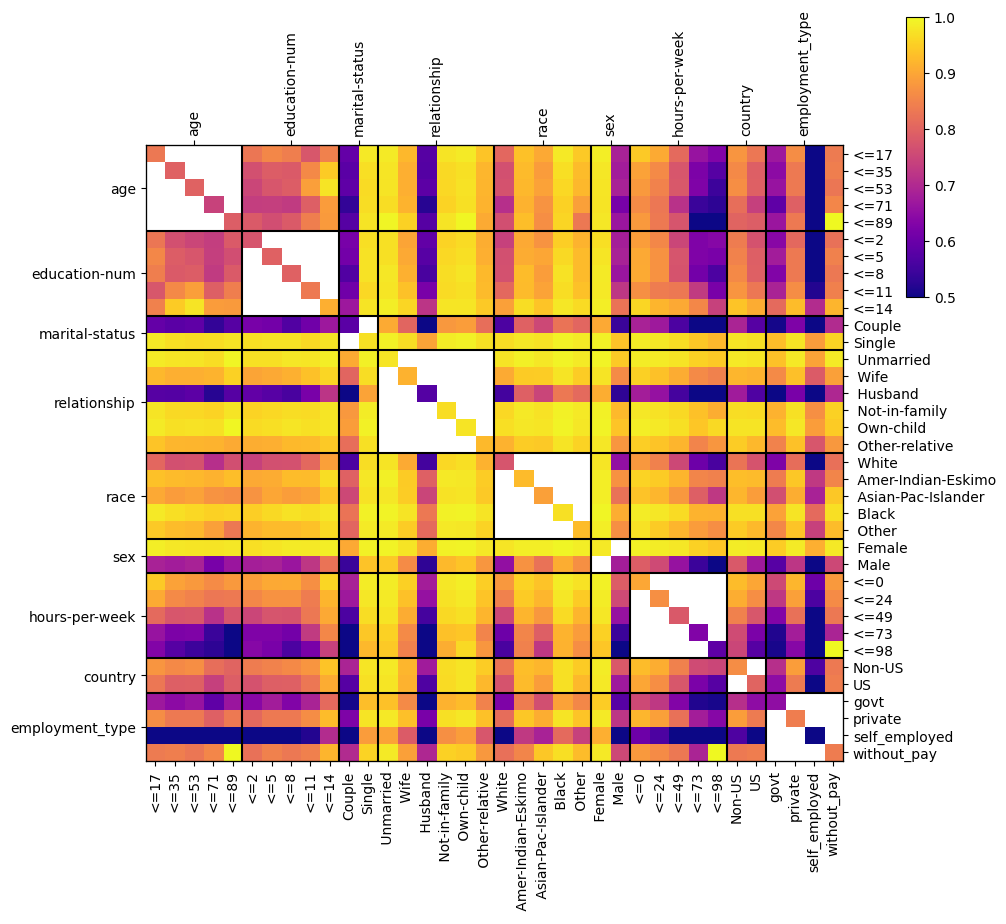

In [13]:
from copy import deepcopy

import matplotlib
import matplotlib.pyplot as plt

cmap = matplotlib.cm.plasma
features = cat_per_feat.keys()

syn_matrix, _ = intersection_matrix(
    data=gen_data,
    model=model,
    n_min=1,
    cols=cols,
    discrete_columns=discrete_columns,
    trained_model_dict=trained_model_dict,
)
matrix = deepcopy(syn_matrix)

new_cat = []
for val in my_cats:
    if isinstance(val, int):
        new_cat.append(f"<={val}")
    else:
        new_cat.append(val)
columns = cols
# matrix += matrix.T
fig, ax1 = plt.subplots(figsize=(9, 8))
im = ax1.imshow(matrix, interpolation="nearest", aspect="auto", cmap=cmap)
num_cats_per_feat = [
    len(cat_per_feat[col]) for col in columns if col not in ["y", "yhat"]
]
cumsum_features = np.cumsum(num_cats_per_feat) - 0.5
ax1.set_xticks(range(len(all_cats)))
ax1.set_xticklabels(new_cat, rotation=90)
ticks_features = cumsum_features - 0.5 * np.array(num_cats_per_feat)
ax1.set_yticks(ticks_features)
ax1.set_yticklabels(features)
for feature in range(len(features))[:-1]:
    ax1.axvline(cumsum_features[feature], color="black")
    ax1.axhline(cumsum_features[feature], color="black")
ax2 = ax1.twinx()
ax2.imshow(matrix, interpolation="nearest", aspect="auto", alpha=0)
ax2.set_yticks(range(len(all_cats)))
ax2.set_yticklabels(new_cat)
ax3 = ax1.twiny()
ax3.imshow(matrix, interpolation="nearest", aspect="auto", alpha=0)
ax3.set_xticks(ticks_features)
ax3.set_xticklabels(features, rotation=90)
position = fig.add_axes([0.97, 0.69, 0.02, 0.35])

fig.colorbar(im, ax=ax1, orientation="vertical", cax=position)
im.set_clim(0.5, 1)
plt.show()
